# Firing vs. stimulation frequency for different irradiance and expression levels

Here we'll replicate figure 4 of Foutz et al., 2012, relating firing rate to stimulation frequency for (a) a range of irradiances and (b) a range of channel densities. Stimulation is a train of 5-ms pulses.

Original figure:

<img src="foutz12_4_original.jpg" alt="Foutz et al. 2012 Figure 4" height="300"/>
<!-- ![Foutz et al., 2012 Figure 4](foutz12_4_original.jpg) | ![Replication of Foutz et al., 2012 Figure 4](foutz12_4_replicated.svg) -->

In [102]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"
matplotlib.rcParams['svg.fonttype'] = "none"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# We can run all the simulations at once using 5 neurons
# the 1.2*Irr0_thres, 1*rho condition is repeated in the two subpanels
from opto_val import lif, adex, Iopto_gain_from_factor
from brian2 import SpikeMonitor, Network, StateMonitor, prefs
from cleosim import CLSimulator
from cleosim.opto import *

prefs.codegen.target = "numpy"


def make_ngs(n):
    return [
        lif(n, "LIF_simple"),
        lif(n, "LIF_Markov"),
        adex(n, "AdEx_simple"),
        adex(n, "AdEx_Markov"),
    ]

ngs = make_ngs(5)
spike_mons = {}
from cleosim.coordinates import assign_coords_rand_rect_prism

for ng in ngs:
    spike_mons[ng.name] = SpikeMonitor(ng, record=True)
    # distance of 1 mm
    assign_coords_rand_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), zlim=(1, 1))

net = Network(*ngs, *spike_mons.values())
sim = CLSimulator(net)

simple_opto_gain_factor = 15

sopto = OptogeneticIntervention(
    name="sopto",
    opsin_model=ProportionalCurrentModel(
        # same as threshold figure, but may be too weak
        Iopto_per_mW_per_mm2=Iopto_gain_from_factor(simple_opto_gain_factor)
    ),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
mopto = OptogeneticIntervention(
    name="mopto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
# neurons 1, 3, 4 (0-index) for varying channel density
rho_rel = [1, 1, 1, 1.5, 0.75]
sim.inject_stimulator(sopto, ngs[0], ngs[2], rho_rel=rho_rel)
sim.inject_stimulator(mopto, ngs[1], ngs[3], rho_rel=rho_rel)
# neurons 0, 1, and 2 will have varying irradiance
Irr0_ratio = [1.4, 1.2, 1, 1.2, 1.2]
for opto_syn in [*sopto.opto_syns.values(), *mopto.opto_syns.values()]:
    opto_syn.T *= Irr0_ratio
    # opto_syn.T[0] *= 1.4
    # opto_syn.T[1] *= 1.2
    # opto_syn.T[3:] *= 1.2

sim.network.store()

We need irradiance thresholds for each neuron type for a 5-ms pulse:

In [104]:
from opto_val import get_Irr0_thres

Irr0_thres = {ng.name: {} for ng in ngs}
for ng in make_ngs(1):
    simple_opto = "simple" in ng.name
    Irr0_thres[ng.name] = get_Irr0_thres(
        [5],
        1,
        ng,
        simple_opto=simple_opto,
        gain_factor=simple_opto_gain_factor,
        precision=0.1,
        target="numpy",
    )[0]
Irr0_thres


{'LIF_simple': 134.2010498046875,
 'LIF_Markov': 12.7410888671875,
 'AdEx_simple': 164.8712158203125,
 'AdEx_Markov': 16.8609619140625}

We prepare a pandas dataframe to store data in tidy format:

In [105]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pulse_rate', 'firing_rate', 'Irr0/Irr0_thres', 'rho_rel'])
df

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel


Next we load the original data for comparison. First, from the top panel, showing data for different irradiance levels.

In [106]:
wpd_data_irr = pd.read_csv('data/foutz12_4a_wpd.csv')
wpd_data_irr.head()

,1.4,Unnamed: 1,1.2,Unnamed: 3,1,Unnamed: 5
0,X,Y,X,Y,X,Y
1,0.2440316822846853,0.685016323314187,0.5926483712628183,0.8609141055949578,0.7669567157518813,0.15732297647190308
2,97.3337795626952,97.07700101317123,90.71006247211064,90.21698750422155,10.702532351628733,0.5091185410334447
3,105.70058009817045,101.65034335247103,99.77409638554217,94.0867387143983,25.518741633199454,3.323483057525607
4,114.93892235609103,103.9370145221209,119.47093931280678,97.95648992457504,31.445225345827737,5.258358662614


In [107]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data_irr)):
        if pd.isna(wpd_data_irr.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "MCHH_Markov",  # name
            wpd_data_irr.iloc[i_row, i_col],  # pulse rate
            wpd_data_irr.iloc[i_row, i_col + 1],  # firing rate
            wpd_data_irr.columns[i_col],  # Irr0/Irr0_thres
            1,  # rho_rel
        ]
df = df.astype(
    {
        "pulse_rate": float,
        "firing_rate": float,
        "Irr0/Irr0_thres": float,
        "rho_rel": float,
    }
)
df.tail()


,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
39,MCHH_Markov,139.167782,91.975965,1.0,1.0
40,MCHH_Markov,150.672133,96.549308,1.0,1.0
41,MCHH_Markov,156.075692,97.077001,1.0,1.0
42,MCHH_Markov,176.644076,101.298548,1.0,1.0
43,MCHH_Markov,199.827086,105.871890,1.0,1.0


Now for the bottom panel with varying levels of opsin expression:

In [108]:
wpd_data_exp = pd.read_csv('data/foutz12_4b_wpd.csv')
wpd_data_exp.head()

,1.5,Unnamed: 1,1,Unnamed: 3,0.75,Unnamed: 5
0,X,Y,X,Y,X,Y
1,0.18040727560301661,0.06011857180919833,0.07743508633190288,0.06011857180919833,0.48932384341637913,0.06011857180919833
2,89.76621194147889,89.98817612576605,90.2810728878345,89.98817612576605,20.36295637274287,20.148214761524116
3,100.37234743640441,100.29243272049027,99.8574864900488,93.943345323741,29.527481217872705,21.605382360778037
4,110.46362198497432,105.18435251798559,120.14300777645975,97.89851452171592,37.147423223935704,27.329969357847034


In [109]:
for i_col in [0, 2, 4]:
    for i_row in range(1, len(wpd_data_exp)):
        if pd.isna(wpd_data_exp.iloc[i_row, i_col]):
            continue
        df.loc[len(df)] = [
            "MCHH_Markov",  # name
            wpd_data_exp.iloc[i_row, i_col],  # pulse rate
            wpd_data_exp.iloc[i_row, i_col + 1],  # firing rate
            1.2,  # Irr0/Irr0_thres
            wpd_data_exp.columns[i_col],  # rho_rel
        ]
df.tail()

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
79,MCHH_Markov,161.33188348490842,98.00259792166267,1.2,0.75
80,MCHH_Markov,170.0845195729538,99.8760991207034,1.2,0.75
81,MCHH_Markov,179.8668775537103,104.1435185185185,1.2,0.75
82,MCHH_Markov,190.16409648082248,106.32926991739942,1.2,0.75
83,MCHH_Markov,199.63753789376568,105.91293631761255,1.2,0.75


In [110]:
from math import sin, tau
from brian2 import Hz

data_already_generated = True
if not data_already_generated:
    pulse_rates = np.linspace(0.1, 200, 20)
    # pulse_rates = [20, 60, 100, 200]
    for pulse_rate in pulse_rates * Hz:
        sim.network.restore()
        # use sine curve to define pulse train
        # need threshold above which sine will be over for 5 ms at a time
        t_peak = 1 / (4 * pulse_rate)  # where sine curve peaks
        t_pulse_start = t_peak - 2.5 * ms  # 2.5 ms to either side of peak -> 5 ms pulse
        sin_thres = sin(tau * pulse_rate * t_pulse_start)
        for ng_name, opto_syn in sopto.opto_syns.items():
            eq = f"Irr0 = {Irr0_thres[ng_name]}*mwatt/mm2 * int(sin({tau}*pulse_rate*t) >= sin_thres)"
            opto_syn.run_regularly(eq)
        for ng_name, opto_syn in mopto.opto_syns.items():
            eq = f"Irr0 = {Irr0_thres[ng_name]}*mwatt/mm2 * int(sin({tau}*pulse_rate*t) >= sin_thres)"
            opto_syn.run_regularly(eq)
        stim_params = {"pulse_rate": pulse_rate, "sin_thres": sin_thres}
        duration_s = 0.4
        sim.run(duration_s * second, namespace=stim_params)
        for ng_name, mon in spike_mons.items():
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "name": ng_name,
                            "pulse_rate": pulse_rate / Hz,
                            # need to wrap VariableView in array to copy
                            "firing_rate": np.array(mon.count_) / duration_s,
                            "Irr0/Irr0_thres": Irr0_ratio,
                            "rho_rel": rho_rel,
                        }
                    ),
                ]
            )

    df.to_csv("data/pr_fr_irr_exp.csv", index=False)
    df.tail()


In [111]:
df = pd.read_csv('data/pr_fr_irr_exp.csv')
df.head()

,name,pulse_rate,firing_rate,Irr0/Irr0_thres,rho_rel
0,MCHH_Markov,0.244032,0.685016,1.4,1.0
1,MCHH_Markov,97.333780,97.077001,1.4,1.0
2,MCHH_Markov,105.700580,101.650343,1.4,1.0
3,MCHH_Markov,114.938922,103.937015,1.4,1.0
4,MCHH_Markov,122.608490,104.640606,1.4,1.0


WARNING    /tmp/ipykernel_29651/749712918.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df.rho_rel == 1],
 [py.warnings]
WARNING    /tmp/ipykernel_29651/749712918.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df['Irr0/Irr0_thres']== 1.2],
 [py.warnings]


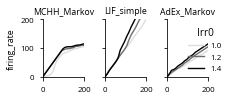

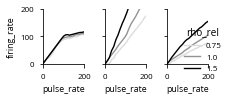

In [168]:
def plot_fr_2panel(data, palette):
    kwargs = {
        "kind": "line",
        "col": "name",
        "x": "pulse_rate",
        "y": "firing_rate",
        # "height": 1.6,
        # "aspect": 0.7,
        "palette": palette,
        "legend": True,
        "facet_kws": {'legend_out': True},
    }
    g_irr = sns.relplot(
        data=data[df.rho_rel == 1],
        hue="Irr0/Irr0_thres",
        **kwargs,
    )
    g_exp = sns.relplot(
        data=data[df['Irr0/Irr0_thres']== 1.2],
        hue="rho_rel",
        **kwargs,
    )

    g_irr.set_axis_labels(x_var="")
    g_irr.set_titles(col_template="{col_name}")
    g_irr.legend.set_title("Irr0")
    # g_irr.set_xticklabels([])
    g_exp.set_titles(col_template="")

    for g in (g_irr, g_exp):
        g.set(xlim=(0, pulse_rates[-1]), ylim=(0, pulse_rates[-1]))
        # g.legend.remove()
        # g.axes[0, 2].legend(
        #     handles=g.legend.legendHandles,
        #     loc="upper left",
        #     title="title",
        # )
        g.fig.set_figwidth(3.1)
        g.fig.set_figheight(1.5)
        g.add_legend()
        g.fig.tight_layout()
    return g_irr, g_exp


g_irr, g_exp = plot_fr_2panel(
    df[~df.name.str.contains("LIF_Markov|AdEx_simple", regex=True)],
    palette="blend:#DDDDDD,black",
)
g_irr.fig.savefig("img/fig/opto_pr_fr_irr.svg")
g_exp.fig.savefig("img/fig/opto_pr_fr_exp.svg")


WARNING    /tmp/ipykernel_29651/749712918.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df.rho_rel == 1],
 [py.warnings]
WARNING    /tmp/ipykernel_29651/749712918.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=data[df['Irr0/Irr0_thres']== 1.2],
 [py.warnings]


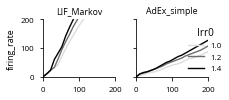

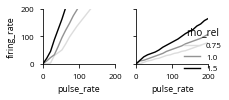

In [169]:
g_irr, g_exp = plot_fr_2panel(
    df[df.name.str.contains("LIF_Markov|AdEx_simple", regex=True)],
    palette="blend:#DDDDDD,black",
)
g_irr.fig.savefig("img/fig/opto_pr_fr_irr_supp.svg")
g_exp.fig.savefig("img/fig/opto_pr_fr_exp_supp.svg")

